# Predictions

In [176]:
import pandas as pd
import sketch

import lightgbm as lgb 
from sklearn.metrics import r2_score, mean_absolute_error
import pickle

In [177]:
df_moex = pd.read_csv("clean_data/pred_moex.csv")
df_moex.rename(columns={'Unnamed: 0': "quarter", "value":"moex"}, inplace=True)
df_moex.head(3)

,quarter,moex
0,2022-01-01,461.0
1,2022-04-01,461.0
2,2022-07-01,461.0


In [178]:
df_bond = pd.read_csv("clean_data/pred_bond.csv")
df_bond.rename(columns={'Unnamed: 0': "quarter", "value":"rgb_price"}, inplace=True)
df_bond.head(3)

,quarter,rgb_price
0,2022-01-01,6.360632e+10
1,2022-04-01,8.804385e+10
2,2022-07-01,7.901886e+10


In [179]:
df_ppl = pd.read_csv("clean_data/pred_count_people.csv")
df_ppl.rename(columns={'Unnamed: 0': "quarter", "value":"value"}, inplace=True)
df_ppl.head(3)

,quarter,clnt_id
0,2022-01-01,4496.708670
1,2022-04-01,4417.655017
2,2022-07-01,4523.592399


In [180]:
df_employ = pd.read_csv("clean_data/pred_unemploy.csv")
df_employ.rename(columns={'Unnamed: 0': "quarter", "value":"employ"}, inplace=True)
df_employ.head(3)

,quarter,employ
0,2022-01-01,13778.757049
1,2022-04-01,13641.737420
2,2022-07-01,13687.231508


In [181]:
pred_df = pd.merge(pd.merge(pd.merge(df_moex, df_bond, on='quarter'), df_ppl, on='quarter'), df_employ, on='quarter')
pred_df.head()

,quarter,moex,rgb_price,clnt_id,employ
0,2022-01-01,461.0,6.360632e+10,4496.708670,13778.757049
1,2022-04-01,461.0,8.804385e+10,4417.655017,13641.737420
2,2022-07-01,461.0,7.901886e+10,4523.592399,13687.231508
3,2022-10-01,461.0,6.926884e+10,4536.165980,13929.105980
4,2023-01-01,461.0,7.225215e+10,4559.398183,14181.101295


In [182]:
pred_df['year'] = pd.to_datetime(pred_df.quarter).dt.year
pred_df['month'] = pd.to_datetime(pred_df.quarter).dt.month
pred_df['day'] = pd.to_datetime(pred_df.quarter).dt.day
pred_df.drop(columns=['quarter'], inplace=True)
pred_df.head(3)

,moex,rgb_price,clnt_id,employ,year,month,day
0,461.0,6.360632e+10,4496.708670,13778.757049,2022,1,1
1,461.0,8.804385e+10,4417.655017,13641.737420,2022,4,1
2,461.0,7.901886e+10,4523.592399,13687.231508,2022,7,1


In [183]:
with open('model/placeholder.pkl', 'rb') as f:
    params = pickle.load(f)
params["verbose"] = -1

In [184]:
quarterly_data = pd.read_csv('clean_data/quarterly_data.csv', index_col=0)

In [185]:
dataframes_slctn_cluster = [None]*4
# Select all columns except cluster and slctn_number by specific value of cluster AND slctn_number
cluster_vals = range(4)
slctn_number_vals = range(4)

# Get the columns to keep
columns_to_keep = quarterly_data.columns.difference(['cluster', 'slctn_nmbr', 'age'])

for cluster_val in cluster_vals:
    dataframes_slctn_cluster[cluster_val] = [None] * 4
    for slctn_number_val in slctn_number_vals:
        filtered_df = quarterly_data[(quarterly_data['cluster'] == cluster_val) & (quarterly_data['slctn_nmbr'] == slctn_number_val)]
        res = filtered_df[columns_to_keep]
        #res['prev_npo_sum'] = res['npo_sum'].shift(1,fill_value=res.iloc[0]['npo_sum'])
        dataframes_slctn_cluster[cluster_val][slctn_number_val] = res

dataframes_slctn_cluster[1][1].head(3)

,clnt_id,day,employ,moex,month,npo_sum,rgb_price,year
3,42,1,5666.0,2.452452e+10,1,16968.64,11362.0,2005
15,40,1,5666.0,1.532838e+10,4,21955.21,11288.0,2005
27,950,1,5666.0,1.172042e+10,7,7624721.46,11283.0,2005


In [186]:
def train_test_split(df):
    train_size = int(len(df) * 0.8)
    train_data, test_data = df.iloc[:train_size, :], df.iloc[train_size:, :]
    X_train = train_data.loc[:, df.columns != "npo_sum"]
    y_train = train_data.loc[:, "npo_sum"]
    X_test = test_data.loc[:, df.columns != "npo_sum"]
    y_test = test_data.loc[:, "npo_sum"]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(dataframes_slctn_cluster[3][3])

In [187]:
model = lgb.LGBMRegressor(**params, )
model.fit(X_train, y_train)
pred = model.predict(X_test)
r2_score(y_test, pred)

-0.8011411548052882

In [194]:
results = pd.DataFrame(index=pred_df.index, columns=pred_df.columns)

In [231]:
%%time
predictions_per_selection = [None]*4
for i in slctn_number_vals:
    predictions_per_selection[i] = [None]*4
    for j in cluster_vals:
        print("--------------")
        print(f"Current Selection Number is {i} and Cluster Number is {j}")
        X_train, y_train, X_test, y_test = train_test_split(dataframes_slctn_cluster[i][j])
        with open(f'model/model_parameters_{i}_{j}.pkl', 'rb') as f:
            params = pickle.load(f)
        params["verbose"] = -1
        model = lgb.LGBMRegressor(**params, )
        print(X_train.columns)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = r2_score(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        print(f"R2 = {r2}\tMAE={mae}")
        real_pred = model.predict(pred_df)
        predictions_per_selection[i][j] = real_pred.reshape(-1,1)
    results[f"prediction_S{i}"] = np.sum(predictions_per_selection[i], axis=0)

--------------
Current Selection Number is 0 and Cluster Number is 0
Index(['clnt_id', 'day', 'employ', 'moex', 'month', 'rgb_price', 'year'], dtype='object')
R2 = -237.7037500107201	MAE=350070.8423483384
--------------
Current Selection Number is 0 and Cluster Number is 1
Index(['clnt_id', 'day', 'employ', 'moex', 'month', 'rgb_price', 'year'], dtype='object')
R2 = -9.339510674872583	MAE=634855.5179458753
--------------
Current Selection Number is 0 and Cluster Number is 2
Index(['clnt_id', 'day', 'employ', 'moex', 'month', 'rgb_price', 'year'], dtype='object')
R2 = -3.8023255609227125	MAE=33799551.960328236
--------------
Current Selection Number is 0 and Cluster Number is 3
Index(['clnt_id', 'day', 'employ', 'moex', 'month', 'rgb_price', 'year'], dtype='object')
R2 = -0.4785500100384692	MAE=137718.60288898676
--------------
Current Selection Number is 1 and Cluster Number is 0
Index(['clnt_id', 'day', 'employ', 'moex', 'month', 'rgb_price', 'year'], dtype='object')
R2 = -0.663057940

In [232]:
results = results.loc[:,[f'prediction_S{i}' for i in range(4)]]

In [233]:
results['year'] = pred_df['year']
results['month'] = pred_df['month']
results['day'] = pred_df['day']

In [246]:
import datetime
# Create a new column 'date' by combining year, month and day columns
results['quarter'] = results.apply(lambda x: datetime.datetime(int(x['year']), int(x['month']), int(x['day'])), axis=1)

# Check the dataframe
results.tail()

,prediction_S0,prediction_S1,prediction_S2,prediction_S3,year,month,day,quarter
19,1.018705e+07,2.105919e+06,7.460035e+06,9.275085e+07,2026,10,1,2026-10-01
20,1.020031e+07,2.105919e+06,7.424083e+06,9.278179e+07,2027,1,1,2027-01-01
21,1.018705e+07,2.105919e+06,7.460035e+06,9.275085e+07,2027,4,1,2027-04-01
22,1.018705e+07,2.105919e+06,7.460035e+06,9.275085e+07,2027,7,1,2027-07-01
23,1.018705e+07,2.105919e+06,7.460035e+06,9.275085e+07,2027,10,1,2027-10-01


In [235]:
results.to_csv('front/predictions.csv')

In [236]:
import plotly.express as px

/Users/snopoff/miniconda3/envs/nspf/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



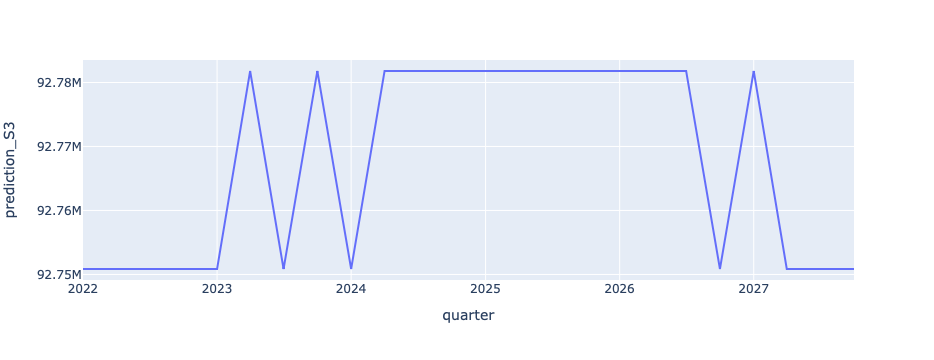

In [245]:
px.line(results, x='quarter', y=f'prediction_S{3}')